# Аналитика для интернет-магазина

### Задача
Интернет-магазине «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Описание данных

Name — название игры  
Platform — платформа  
Year_of_Release — год выпуска  
Genre — жанр игры  
NA_sales — продажи в Северной Америке (миллионы проданных копий)  
EU_sales — продажи в Европе (миллионы проданных копий)  
JP_sales — продажи в Японии (миллионы проданных копий)  
Other_sales — продажи в других странах (миллионы проданных копий)  
Critic_Score — оценка критиков (максимум 100)  
User_Score — оценка пользователей (максимум 10)  
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.  
Данные за 2016 год могут быть неполными.  

## Загрузка данных и библиотек

In [18]:
import pandas  as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
! pip install missingno 
import missingno as msno

In [3]:
# чтение файла с данными и сохранение в data
try:
    data = pd.read_csv('/datasets/games.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [4]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В данном датафрейме всего 16715 строк, имеются пропуски, дубликаты, нарушение в типизации данных и названия колонок имеют лексическую ошибку.

## Предобработка данных

### Приведение нижнему регистру

In [6]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработка пропусков

In [7]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

<AxesSubplot:>

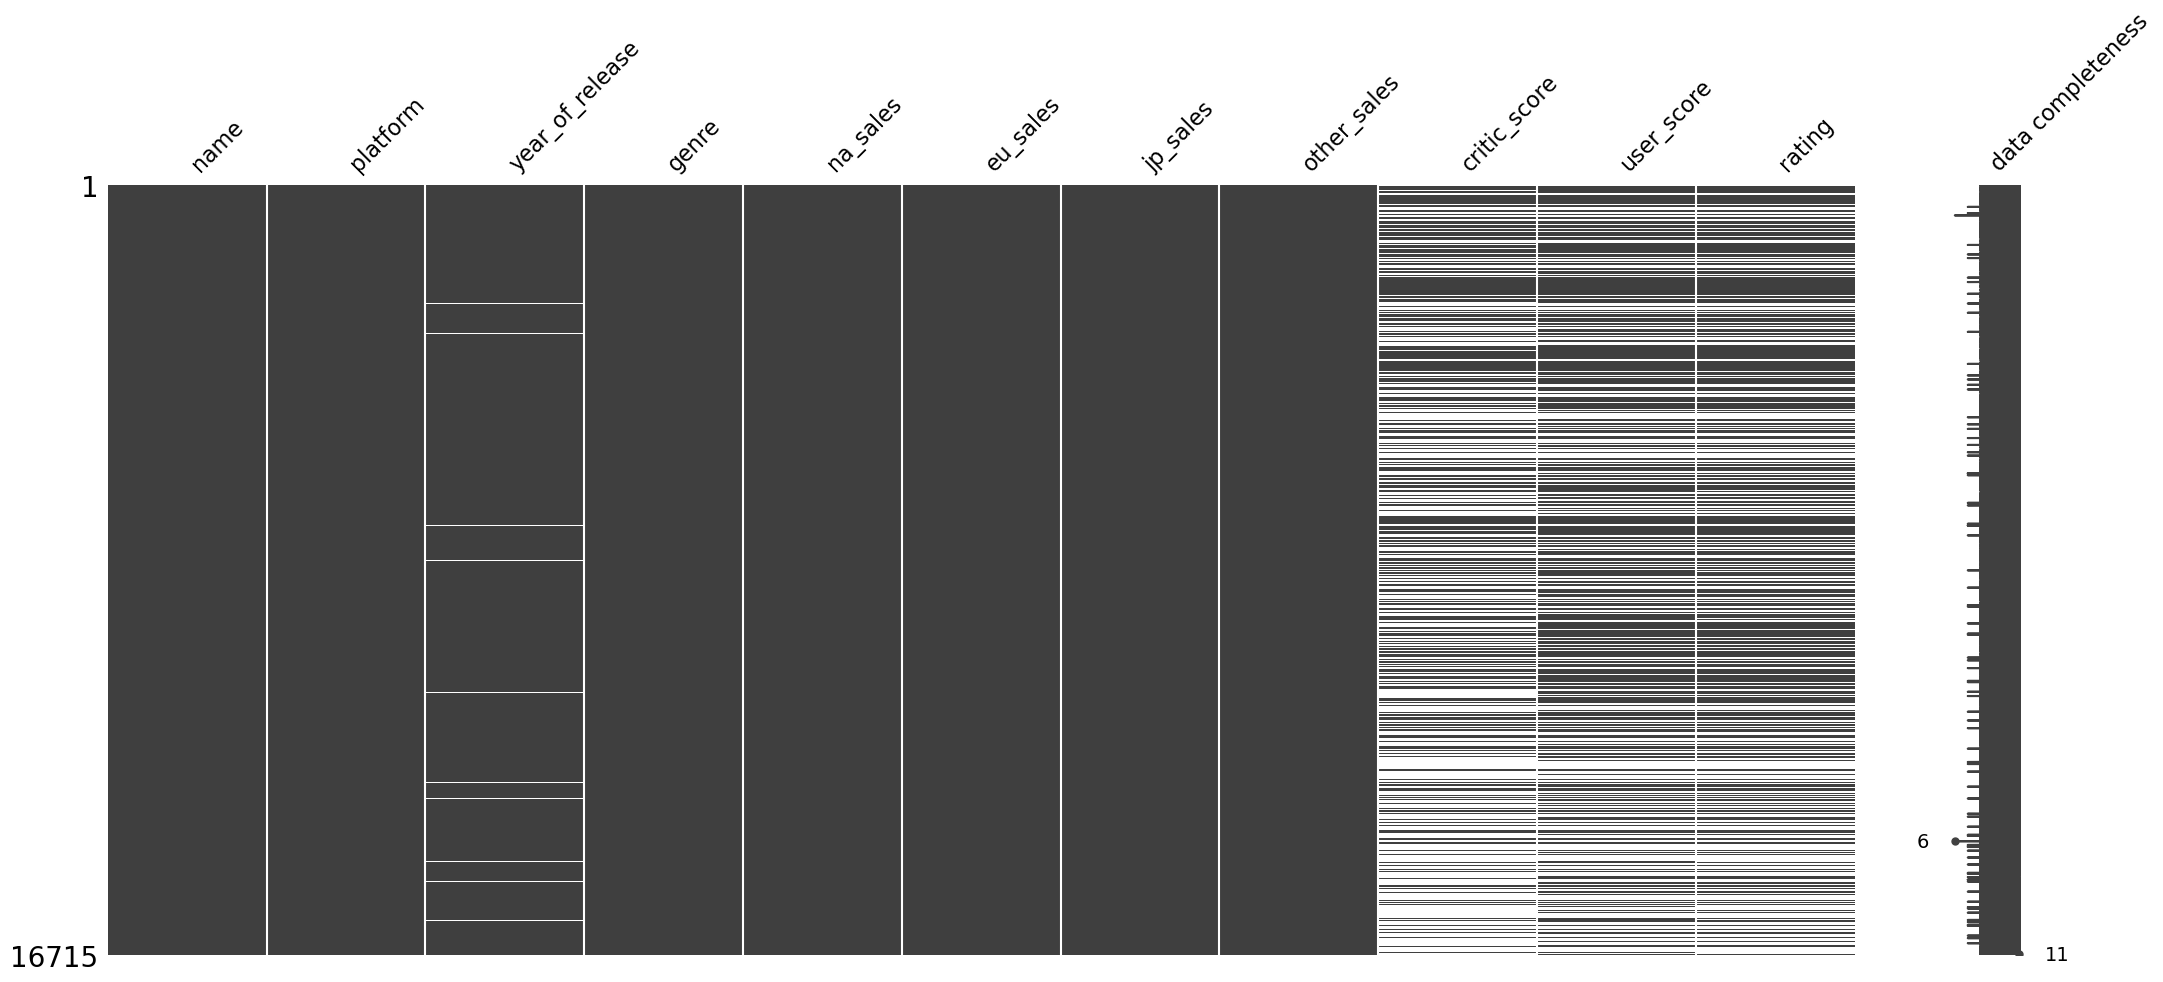

In [8]:
msno.matrix(data, labels=True)

Удалим строки спропусками в столбцах 'name' и 'year_of_realease', так как их немного.

In [14]:
data = data.dropna(subset = ['name'])
data = data.dropna(subset=['year_of_release'])
data.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

Значения оценок заменим на отрицательную величину и в дальнейшем не будем рассматривать их при вычислении среднего и других показателей.

In [15]:
data['critic_score'] = data['critic_score'].fillna('-1')
data['user_score'] = data['user_score'].fillna(-1)
data['user_score'].value_counts()

-1     8981
7.8     322
8       285
8.2     276
8.3     252
       ... 
1.5       2
0.3       2
1         2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

Имеем 2376 случаев с tbd, о которых ничего сказано. Но скорей всего это отсутсвие оценок по причине не хватки количества, для определения средней. Поэтому данный показатель так же к -1.

In [16]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = -1
data['user_score'].value_counts()

-1     8981
7.8     322
8       285
8.2     276
8.3     252
       ... 
1.5       2
0.3       2
1         2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

In [17]:
data['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

Столбец rating, это рейтинг от организации ESRB. Отсуствующее значение заменим на unknowm.

In [18]:
data['rating'] = data['rating'].fillna('unknown')

In [19]:
data.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

### Проверка дубликатов

In [20]:
data.duplicated().sum()

0

Рассмотрим дубликаты по трем столбцам.

In [21]:
data[data.duplicated(['name', 'platform', 'year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.0,0.0,83.0,5.5,E


In [22]:
data[data['name'] == 'Madden NFL 13']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
507,Madden NFL 13,X360,2012.0,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
3986,Madden NFL 13,Wii,2012.0,Sports,0.47,0.00,0.0,0.03,-1,7.3,E
5887,Madden NFL 13,PSV,2012.0,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
7066,Madden NFL 13,WiiU,2012.0,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Видим дубликат, удалим его.

In [23]:
data = data.drop_duplicates(['name', 'platform', 'year_of_release'])

### Типизация данных

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  float64
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  object 
 9   user_score       16443 non-null  object 
 10  rating           16443 non-null  object 
dtypes: float64(5), object(6)
memory usage: 1.5+ MB


In [26]:
data['year_of_release'] = data['year_of_release'].astype('int32')
data['critic_score'] = data['critic_score'].astype('int32')
data['user_score'] = data['user_score'].astype('float32')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int32  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  int32  
 9   user_score       16443 non-null  float32
 10  rating           16443 non-null  object 
dtypes: float32(1), float64(4), int32(2), object(4)
memory usage: 1.3+ MB


### Суммарные продажи

In [27]:
data['total_sales'] = data.loc[:,['na_sales','eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,unknown,31.38


Провели предобработку: убедились в отсутствии дубликатов, избавились от пропусков, изменили тип данных, привели названия столбцов к правильному виду и посчитали суммарные продажи во всех регионах. Проведён поиск по неизвестным значениям 'tbd' и пропуску в столбце rating и провели обработку.

## Исследовательский анализ данных.

### Сколько игр выпускалось в разные годы

In [28]:
data['year_of_release'].describe()

count    16443.000000
mean      2006.485921
std          5.875546
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

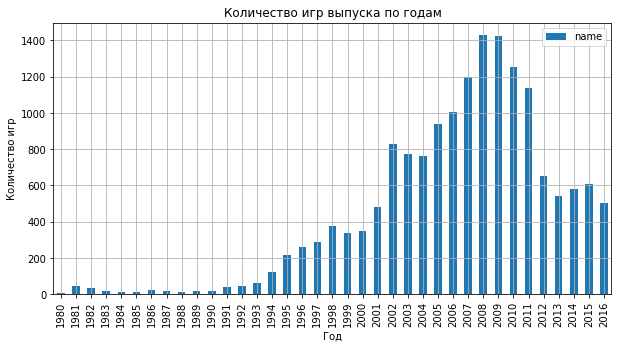

In [29]:
data.pivot_table(index='year_of_release', values='name', aggfunc='count').plot(kind='bar' , grid=True, figsize=(10, 5))

plt.title('Количество игр выпуска по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()

С 1991 года замечается рост выпуска игр по 2009 год, самый пик заметен в 2008-2009 год. Данный рост связан с началом и развитием игр. Спад с 2009 по 2016 связан с многими факторами, а именно большая конкурентность, уменьшение колличества игр, но улучшение качества игр, компаниии изменили подход к созданию.

### Как менялись продажи по платформам

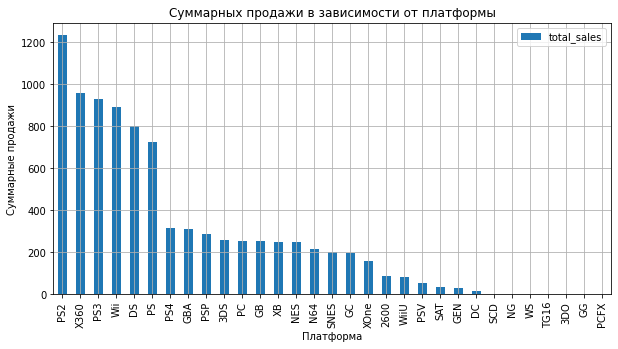

In [30]:
data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).plot(kind='bar' , grid=True, figsize=(10, 5))
plt.title('Суммарных продажи в зависимости от платформы')
plt.xlabel('Платформа')
plt.ylabel('Суммарные продажи')
plt.show()

In [31]:
max_sale = data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).reset_index().head(6)['platform'].tolist()
max_sale

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

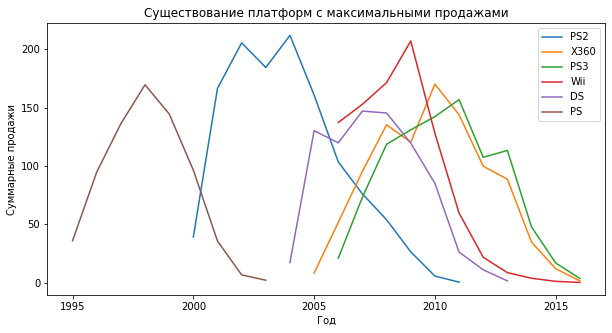

In [40]:
for sale in max_sale:
    (
    data.query('platform == @sale & year_of_release > 1994')
    .pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
    .sort_values('year_of_release', ascending = False)['total_sales']
    .plot(figsize = (10, 5), label=sale)
    )
    plt.title('Существование платформ с максимальными продажами')
    plt.xlabel('Год')
    plt.ylabel('Суммарные продажи')
    plt.legend()

По данному графику, можно сделать выводы, что каждая платформе в среднем живёт 10 лет, пикового значения достигают спустя 5 лет, после происходит спад.  

За какой характерный срок появляются новые и исчезают старые платформы? Я бы ответила, 10 лет, связанное с прогрессирующем временем.  

Для дальнейшей работы выберем 2011 год и не будем брать в учёт года ранее.  

### Какие платформы лидируют по продажам, растут или падают.

In [41]:
one_year = data[data['year_of_release'] >= 2013]
one_year.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,-1.0,unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1,-1.0,unknown,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,-1,-1.0,unknown,11.68
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73,2.6,M,10.24
69,Call of Duty: Ghosts,PS3,2013,Shooter,4.10,3.63,0.38,1.25,71,2.6,M,9.36
72,Minecraft,X360,2013,Misc,5.70,2.65,0.02,0.81,-1,-1.0,unknown,9.18
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58


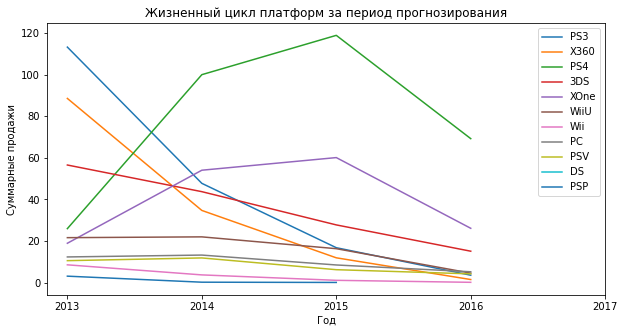

In [42]:
for pl in one_year['platform'].unique():
    (
    one_year.query('platform == @pl')
    .pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
    .sort_values('year_of_release', ascending = False)['total_sales']
    .plot(kind='line', figsize = (10, 5), label=pl)
    )
    plt.title('Жизненный цикл платформ за период прогнозирования')
    plt.xticks(np.arange(2013, 2018, step=1))
    plt.xlabel('Год')
    plt.ylabel('Суммарные продажи')
    plt.legend()

По данному графику следует, что общая тенденция консолей имеет отрицательный характер, но свежие консоли такие, как PS4 и XOne имели успел не так давно, к сегодня пришли к негативной тендеции. Только эти две платформы имеют шансы на перемены в ближайшие года, ведь фокус идёт именно на них.

In [43]:
one_year.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000
mean,2014.477385,0.196019,0.175652,0.063045,0.053726,31.407524,3.048724,0.488442
std,1.089439,0.547730,0.512451,0.233997,0.165693,37.282494,3.963069,1.235226
min,2013.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.010000
25%,2014.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.030000
50%,2014.000000,0.020000,0.030000,0.010000,0.010000,-1.000000,3.500000,0.110000
75%,2015.000000,0.150000,0.130000,0.050000,0.040000,72.000000,7.100000,0.400000
max,2016.000000,9.660000,9.090000,4.350000,3.960000,97.000000,9.300000,21.050000


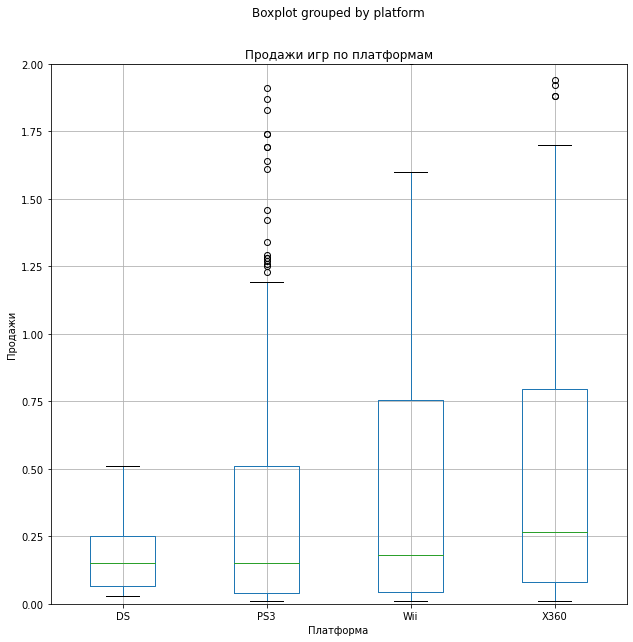

In [44]:
one_year.query('platform in @max_sale').boxplot(by='platform', column=['total_sales'], figsize=(10,10))
plt.ylim(0,2)
plt.title('Продажи игр по платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.show()

Все платформы имеют выбросы, платформа X360 имеет максимальное значение 3-его квартиля и медианный показатель. Платформы PS4 и XOne имеют близкие значение.

### Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.

Корреляция между оценками критиков и продажами по платформе PS4  = 0.40656790206178095


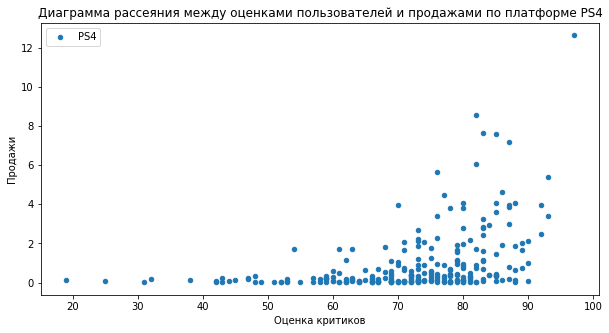

In [74]:
b = 'PS4'
(
one_year.query('platform == @b & critic_score > -1')
    .plot(x='critic_score', 
        y='total_sales', 
        kind='scatter', 
        figsize=(10, 5))
)
plt.title(f'Диаграмма рассеяния между оценками пользователей и продажами по платформе {b}')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи')
plt.legend([b])
print(f'Корреляция между оценками критиков и продажами по платформе {b}  =', one_year.query('platform == @b and critic_score > -1')['critic_score'].corr(one_year.query('platform == @b and critic_score > -1')['total_sales']))
plt.show()

Корреляция между оценками критиков и продажами по платформе PS4  = 0.40656790206178095


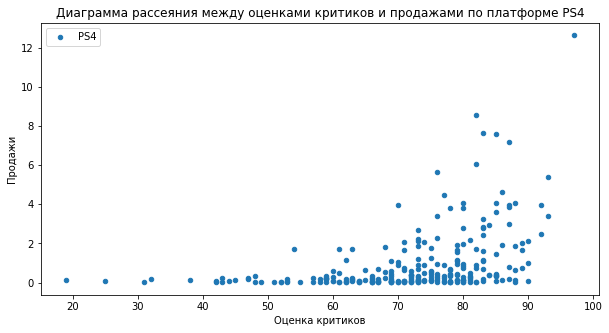

In [50]:
(
one_year.query('platform == @b and critic_score > -1')
    .plot(x='critic_score', 
        y='total_sales', 
        kind='scatter', 
        figsize=(10, 5))
)
plt.title(f'Диаграмма рассеяния между оценками критиков и продажами по платформе {b}')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи')
plt.legend([b])
print(f'Корреляция между оценками критиков и продажами по платформе {b}  =', one_year.query('platform == @b and critic_score > -1')['critic_score'].corr(one_year.query('platform == @b and critic_score > -1')['total_sales']))
plt.show()

По полученным данным, делаем выводы, что сильной зависимости нет, но оценки критиков учитывают в большей степени, чем оценки пользователей.

Оценки пользователей и продажи.

In [51]:
one_year.query('user_score > -1')['user_score'].corr(one_year['total_sales'])

-0.0026078138278985497

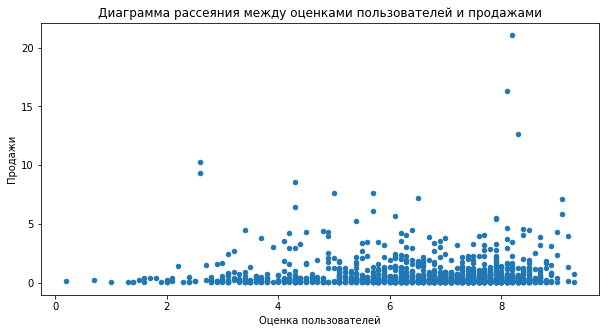

In [52]:
one_year.query('user_score > -1').plot(x='user_score', y='total_sales', kind='scatter', figsize=(10, 5))
plt.title('Диаграмма рассеяния между оценками пользователей и продажами')
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи')
plt.show()

Оценки критиков и продажи.

In [53]:
one_year.query('critic_score > -1')['critic_score'].corr(one_year['total_sales'])

0.3136995151027371

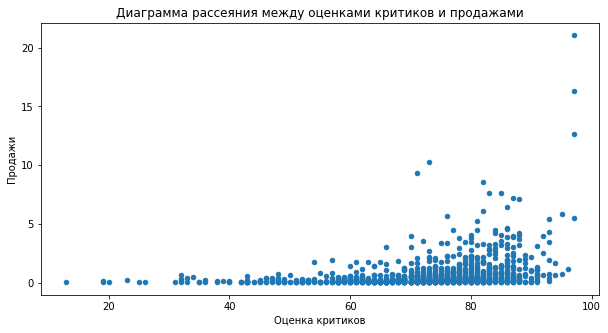

In [54]:
one_year.query('critic_score > -1').plot(x='critic_score', y='total_sales', kind='scatter', figsize=(10, 5))
plt.title('Диаграмма рассеяния между оценками критиков и продажами')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи')
plt.show()

Делаем вывод, что к мнению критиков прислушиваются больше.

###  Общее распределение игр по жанрам. 

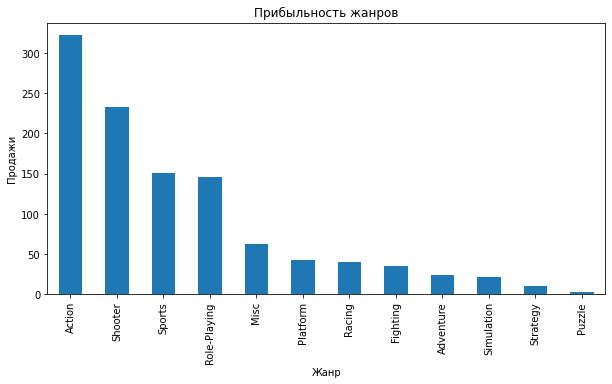

In [55]:
(one_year
 .pivot_table(index='genre', values='total_sales', aggfunc='sum')
 .sort_values('total_sales', ascending=False)
 .plot(kind='bar', y='total_sales', figsize=(10, 5), legend=False)
)
plt.title('Прибыльность жанров')
plt.xlabel('Жанр')
plt.ylabel('Продажи')
plt.show()

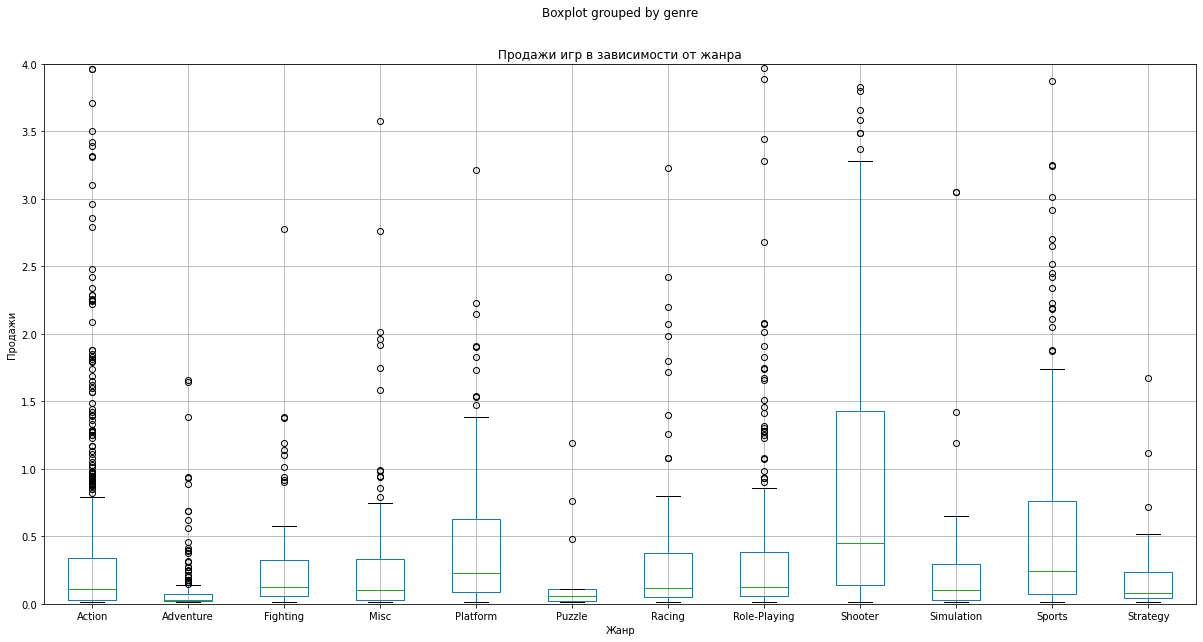

In [58]:
one_year.boxplot(by='genre', column=['total_sales'], figsize=(20,10))
plt.ylim(0,4)
plt.title('Продажи игр в зависимости от жанра')
plt.xlabel('Жанр')
plt.ylabel('Продажи')
plt.show()

In [59]:
one_year.pivot_table(index='genre', values='total_sales', aggfunc='median').sort_values('total_sales', ascending=False)

,total_sales
genre,
Shooter,0.450
Sports,0.240
Platform,0.225
Role-Playing,0.125
Fighting,0.125
Racing,0.120
Action,0.110
Simulation,0.100
Misc,0.100


За последние 6 лет, в топ- входит такие жанры, как Action, Schooter, а третье место разделает Role Playing и Sports.

Для прогнозирование на ближайшие года следует выделить жанры Shooter и Sports, так как они выглядят более стабильно, чем остальные направления.

## Портрет пользователя каждого региона

### Самые популярные платформы (топ-5)

In [60]:
na = one_year[one_year.year_of_release >= 2013].groupby('platform')['na_sales'].agg(na_sales='sum').nlargest(5, 'na_sales').reset_index()
eu = one_year[one_year.year_of_release >= 2013].groupby('platform')['eu_sales'].agg(eu_sales='sum').nlargest(5, 'eu_sales').reset_index()
jp = one_year[one_year.year_of_release >= 2013].groupby('platform')['jp_sales'].agg(jp_sales='sum').nlargest(5, 'jp_sales').reset_index()

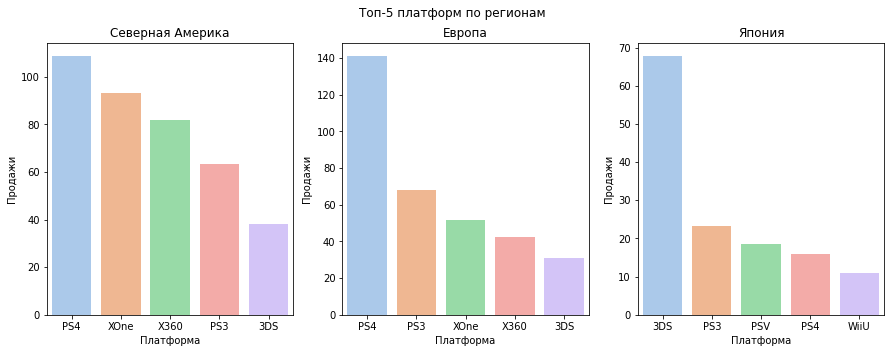

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Топ-5 платформ по регионам')

sns.barplot(y='na_sales', x='platform', data=na, ax=ax[0], palette='pastel')
ax[0].set_title('Северная Америка')
ax[0].set_ylabel('Продажи')
ax[0].set_xlabel('Платформа')

sns.barplot(y='eu_sales', x='platform', data=eu, ax=ax[1], palette='pastel')
ax[1].set_title('Европа')
ax[1].set_ylabel('Продажи')
ax[1].set_xlabel('Платформа')

sns.barplot(y='jp_sales', x='platform', data=jp, ax=ax[2], palette='pastel')
ax[2].set_title('Япония')
ax[2].set_ylabel('Продажи')
ax[2].set_xlabel('Платформа')
plt.show()

В Северной Америке топ-1 занимает платформа X360, Европе - PS4, а в Японии 3DS. Если исследование сделать с 2012 года, то уже в Северной Америке будут изменения, платформа Ps4 займёт первое место, как в Европе.

### Самые популярные жанры (топ-5).

In [62]:
na_genre = one_year[one_year.year_of_release >= 2013].groupby('genre')['na_sales'].agg(na_sales='sum').nlargest(5, 'na_sales').reset_index()
eu_genre = one_year[one_year.year_of_release >= 2013].groupby('genre')['eu_sales'].agg(eu_sales='sum').nlargest(5, 'eu_sales').reset_index()
jp_genre = one_year[one_year.year_of_release >= 2013].groupby('genre')['jp_sales'].agg(jp_sales='sum').nlargest(5, 'jp_sales').reset_index()

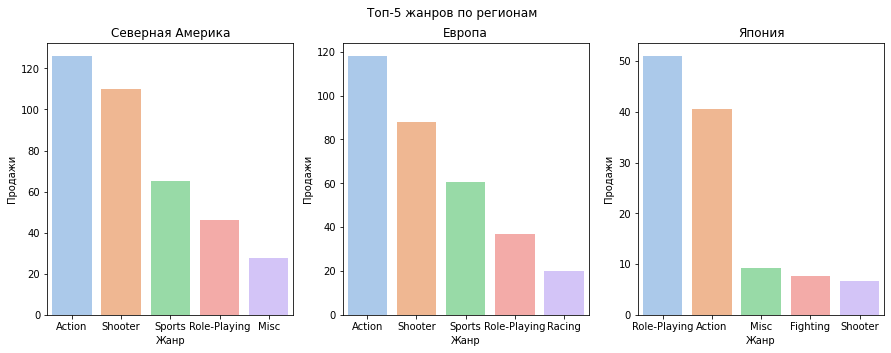

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Топ-5 жанров по регионам')

sns.barplot(y='na_sales', x='genre', data=na_genre, ax=ax[0], palette='pastel')
ax[0].set_title('Северная Америка')
ax[0].set_ylabel('Продажи')
ax[0].set_xlabel('Жанр')

sns.barplot(y='eu_sales', x='genre', data=eu_genre, ax=ax[1], palette='pastel')
ax[1].set_title('Европа')
ax[1].set_ylabel('Продажи')
ax[1].set_xlabel('Жанр')

sns.barplot(y='jp_sales', x='genre', data=jp_genre, ax=ax[2], palette='pastel')
ax[2].set_title('Япония')
ax[2].set_ylabel('Продажи')
ax[2].set_xlabel('Жанр')
plt.show()


В Северной Америке и в Европе популярность имеют игры жанра Action, на втором месте Shooter, на третьем Sports. 

В Японии иная картина,на первом месте находится - жанр Role-Playing, Action на втором, а жанр Shooter - совсем не присутсвует в топ-5.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [64]:
na_rating = one_year[one_year.year_of_release >= 2013].groupby('rating')['na_sales'].agg(na_sales='sum').nlargest(5, 'na_sales').reset_index()
eu_rating = one_year[one_year.year_of_release >= 2013].groupby('rating')['eu_sales'].agg(eu_sales='sum').nlargest(5, 'eu_sales').reset_index()
jp_rating = one_year[one_year.year_of_release >= 2013].groupby('rating')['jp_sales'].agg(jp_sales='sum').nlargest(5, 'jp_sales').reset_index()

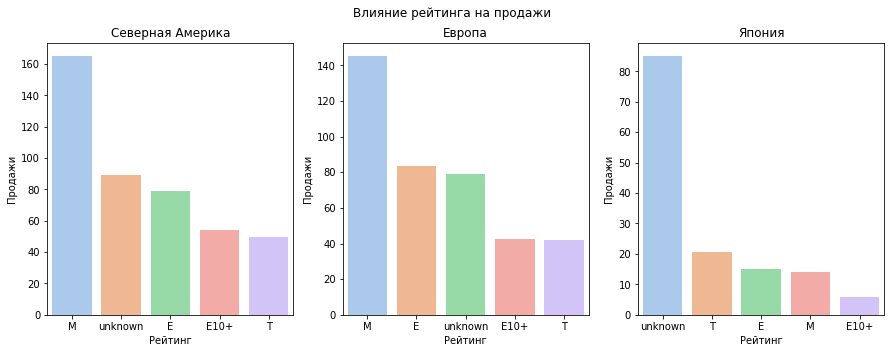

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Влияние рейтинга на продажи')

sns.barplot(y='na_sales', x='rating', data=na_rating, ax=ax[0], palette='pastel')
ax[0].set_title('Северная Америка')
ax[0].set_ylabel('Продажи')
ax[0].set_xlabel('Рейтинг')

sns.barplot(y='eu_sales', x='rating', data=eu_rating, ax=ax[1], palette='pastel')
ax[1].set_title('Европа')
ax[1].set_ylabel('Продажи')
ax[1].set_xlabel('Рейтинг')

sns.barplot(y='jp_sales', x='rating', data=jp_rating, ax=ax[2], palette='pastel')
ax[2].set_title('Япония')
ax[2].set_ylabel('Продажи')
ax[2].set_xlabel('Рейтинг')
plt.show()


Разница влияния рейтинга на продажи прослеживается только между западом и востоком, если в Северной Америке и Европе топ занимает категория М и Е, тогда в Японии Е и Т, в Японии большой показатель неопределенном рейтинге.

## Проверка гипотез

### Проверим: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [66]:
xone = one_year.query('platform == "XOne" and user_score > -1')
xone['user_score'].describe()

count    182.000000
mean       6.521428
std        1.380941
min        1.600000
25%        5.800000
50%        6.800000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64

In [67]:
pc = one_year.query("platform == 'PC' and user_score > -1")
pc['user_score'].describe()

count    155.000000
mean       6.269678
std        1.742381
min        1.400000
25%        5.300000
50%        6.800000
75%        7.600000
max        9.300000
Name: user_score, dtype: float64

Гипотезы  

Н0: Средние пользовательские рейтинги платформ XOne и PC равны  

Н1: Средние пользовательские рейтинги платформ XOne и PC не равны  

In [68]:
alpha = 0.05

results = st.ttest_ind(xone['user_score'], pc['user_score'],equal_var=False,alternative='two-sided')

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.147597032047728
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза не отвергнута, следовательно, можно предположить, что XOne и PC равны, при alpha=0.05

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [69]:
action = one_year.query('genre == "Action" and user_score > -1')
action['user_score'].describe()

count    389.000000
mean       6.837532
std        1.330173
min        2.000000
25%        6.300000
50%        7.100000
75%        7.800000
max        9.100000
Name: user_score, dtype: float64

In [70]:
sports = one_year.query("genre == 'Sports' and user_score > -1")
sports['user_score'].describe()

count    160.000000
mean       5.238125
std        1.783427
min        0.200000
25%        4.100000
50%        5.500000
75%        6.500000
max        8.800000
Name: user_score, dtype: float64

Гипотезы

Заранее перевернём ситуацию, следовательно, если мы отвергнем нулевую гипотезу, Action и Sports не равны

Н0: Средние пользовательские рейтинги жанров Action и Sports равны

Н1: Средние пользовательские рейтинги жанров Action и Sports не равны

In [71]:
alpha = 0.05

results = st.ttest_ind(action['user_score'], sports['user_score'],equal_var=False,alternative='two-sided')

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.4459989209941613e-20
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, следовательно, есть основания предположить, что Action и Sports не равны, при alpha=0.05

Если значений в выборке много больше 30, то распределение Стьюдента настолько близко к нормальному, что можно было бы просто взять нормальное распределение без степеней свободы.  

Но чтобы не усложнять себе жизнь выбором нужного теста, принято просто каждый раз применять t-тест — ведь он работает для выборки любого размера.  

Для проверки гипотезы необходимо установить уровень значимости для того или иного сравнения, обычно его выбирают из размерного ряда 1-10 %, в зависимости от изученности и требовательности к данным. Обычно его устанавливают в среднем значении 0,05.  

## Вывод

В данной работе было выполнено:  

1. Открытие файла с данными и изучение общей ифнормации.  

В данном датафрейме всего 16715 строк, имеются пропуски, дубликаты, нарушение в типизации данных и названия колонок имеют лексическую ошибку.   

2. Предобработка данных.  

Все замечания в данных были устранены: убедились в отсутствии дубликатов, избавились от пропусков, изменили тип данных, привели названия столбцов к правильному виду и посчитали суммарные продажи во всех регионах. Проведён поиск по пропущенным значениям 'tbd'(оценки для Северной Америки) и пропуску в столбце rating и провели обработку. В исключительных местах пропуски заменили на -1, чтобы не исказить статистику.  

3. Исследовательский анализ данных.  

По выполнению исследовательского анализа, делаем выводы, что игровая индустрия прогрессирует в умеренной форме, игры живут в течении 7 лет, но имеют пиковые значение всего 5 лет, за последние года платформа PS4 и XOne имели успех, но так же имеют отрицательную тенденцию, продажи слабо зависят от оценок, но к оценкам критиков прислушиваются, наибольший спросс имеют игры с жанром Action, Schooter, а перспективу имеют игры в жанре Shooter и Sports.  

4. Портрет пользователя каждого региона.  

Портрет пользователя Северной Америки и Европы совпадают, выбирают платформы PS3, PS4, X360, жанры Action, Schooter, Sports и в категории М и Е. Но в Японии портрет отличается, пользователи выбирают 3DS, жанр Role-Playing, Action в категории Е и Т, но с большим количеством неопределенного рейтинга.  

5. Проверьте гипотезы    

Нулевая гипотеза не отвергнута, следовательно, XOne и PC равны. Нулевая гипотеза отвергнута, следовательно, Action и Sports не равны.  